In [1]:
import torch
import random
import torch.nn as nn
import matplotlib.pyplot as pl

In [2]:
from PIL import Image
from pathlib import Path
from torchvision import transforms

In [3]:
from Models.CNN_model import CNN

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
cnn = CNN()
cnn.load_state_dict(torch.load('../assets/cnn_model.pth', map_location = device))
cnn.eval()

CNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=12544, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [6]:
def choose_random_image():
  image_path = random.choice(list(Path('../assets/Dataset/Testing/').glob('*/*.jpg')))
  image_class = image_path.parent.stem

  image = Image.open(image_path)
  image = image.convert('RGB')
  image = image.resize((224, 224))

  return image, image_class

def draw(image, label = ''):
  pl.figure(figsize = (6, 6))
  if label != '': pl.title(f'{label}')
  pl.imshow(image, cmap = 'gray')
  pl.axis('off')
  pl.show()

image_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(mean = [0.1855, 0.1855, 0.1855], std = [0.2003, 0.2003, 0.2004])
])

In [7]:
def prepare_image(path):
  image = Image.open(path)
  image = image.convert('RGB')
  image = image.resize((224, 224))

  pl.figure(figsize = (6, 6))
  pl.imshow(image)
  pl.axis('off')
  pl.show()

  image = image_transform(image)
  image = image.unsqueeze(0)
  image = image.to(device)

  return image

In [8]:
class DeCNN(nn.Module):
  def __init__(self, cnn):
    super(DeCNN, self).__init__()

    self.base_model: CNN = cnn
    self.batches: list = []
    self.sizes: list = []

    self.deconvolution = nn.Sequential(
        nn.MaxUnpool2d(kernel_size = 2, stride = 2),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 16, kernel_size = 3, stride = 1, padding = 1), 

        nn.MaxUnpool2d(kernel_size = 2, stride = 2),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 16, kernel_size = 3, stride = 1, padding = 1),

        nn.MaxUnpool2d(kernel_size = 2, stride = 2),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 3, kernel_size = 3, stride = 1, padding = 1)
    )

  def forward(self, batch: torch.Tensor):
    # Conv forward
    for i, layer in enumerate(self.base_model.features):
      if isinstance(layer, nn.MaxPool2d):
        self.sizes.append(batch.size())
        batch, indices = layer(batch)
        self.base_model.switch_indices[i] = indices
      else:
        batch = layer(batch)
      print(batch.size())

    # DeConv forward
    size_index: int = 2
    for i, layer in enumerate(self.deconvolution):
      if isinstance(layer, nn.MaxUnpool2d):
        batch = layer(batch, self.base_model.switch_indices[8 - i], output_size = self.sizes[size_index])
        size_index -= 1
      else:
        batch = layer(batch)
      self.batches.append(batch)
    return batch

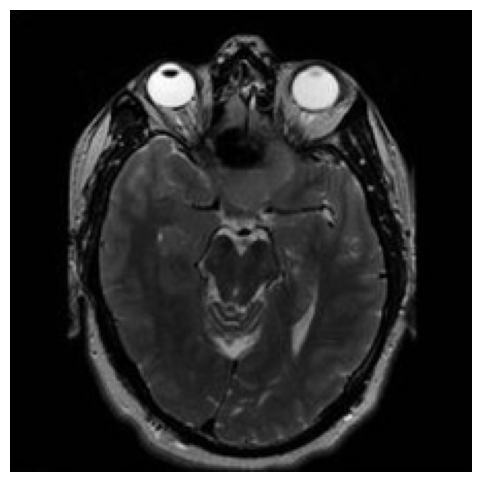

In [9]:
image = prepare_image('test_notumor_2.jpg')

In [10]:
deconv_net = DeCNN(cnn)
deconv_net.to(device)
deconv_net.eval()

reconstructed_image = deconv_net(image).detach().numpy()[0, 2, :]

torch.Size([1, 16, 224, 224])
torch.Size([1, 16, 224, 224])
torch.Size([1, 16, 112, 112])
torch.Size([1, 16, 112, 112])
torch.Size([1, 16, 112, 112])
torch.Size([1, 16, 56, 56])
torch.Size([1, 16, 56, 56])
torch.Size([1, 16, 56, 56])
torch.Size([1, 16, 28, 28])


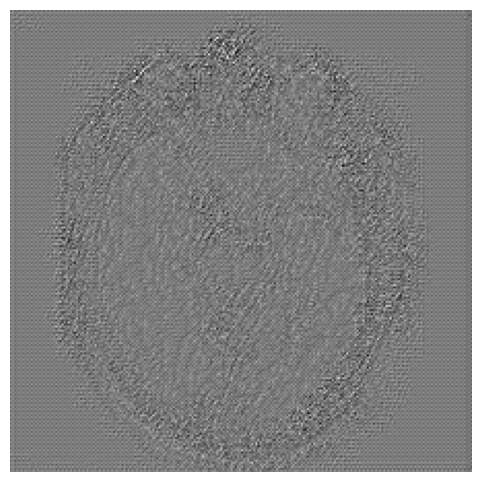

In [11]:
draw(reconstructed_image)

-----
Wizualizacja kolejnych warstw w sieci dekonwolucyjnej.

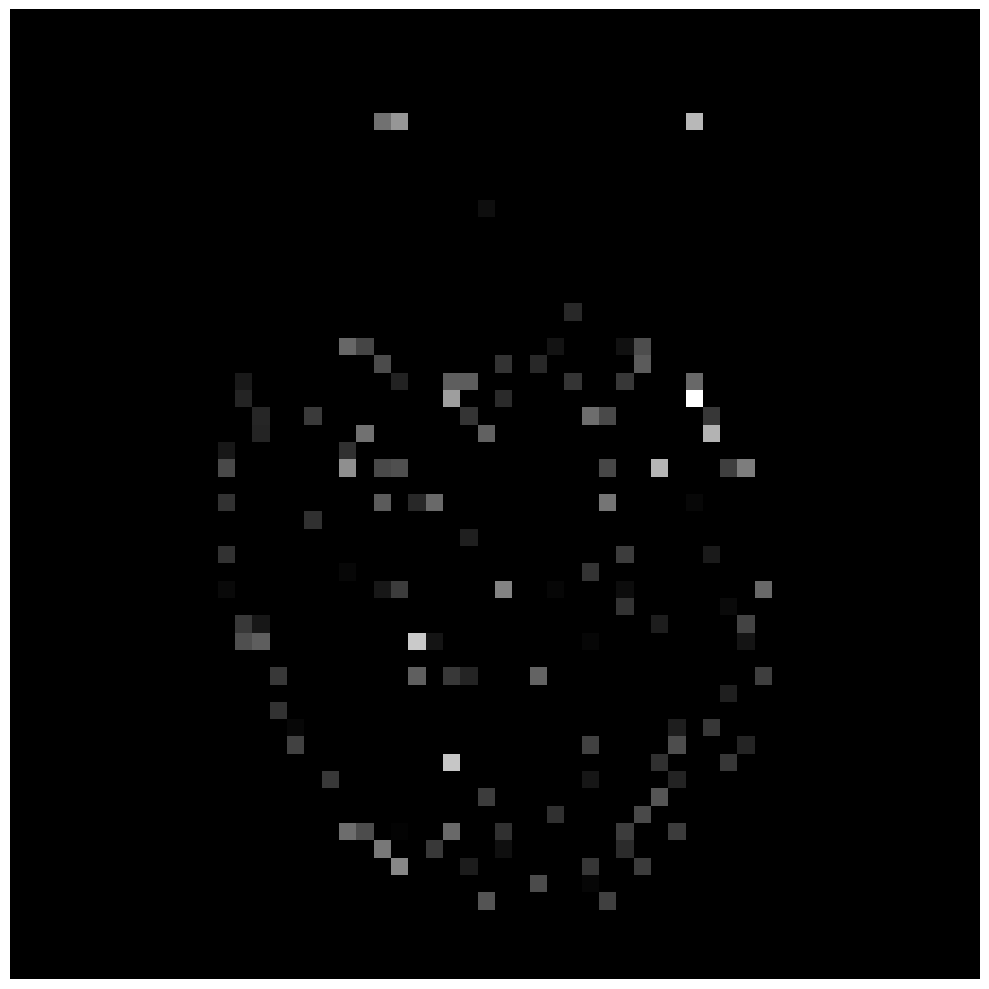

In [12]:
layer_names = [str(name).split('(', 1)[0] for _, name in deconv_net.deconvolution.named_children()]

pl.figure(figsize = (10, 10))
pl.imshow(deconv_net.batches[1].detach().numpy()[0, 2, :], cmap = 'gray')
pl.axis('off')
pl.tight_layout()
# pl.savefig('decnn_first_relu.png')

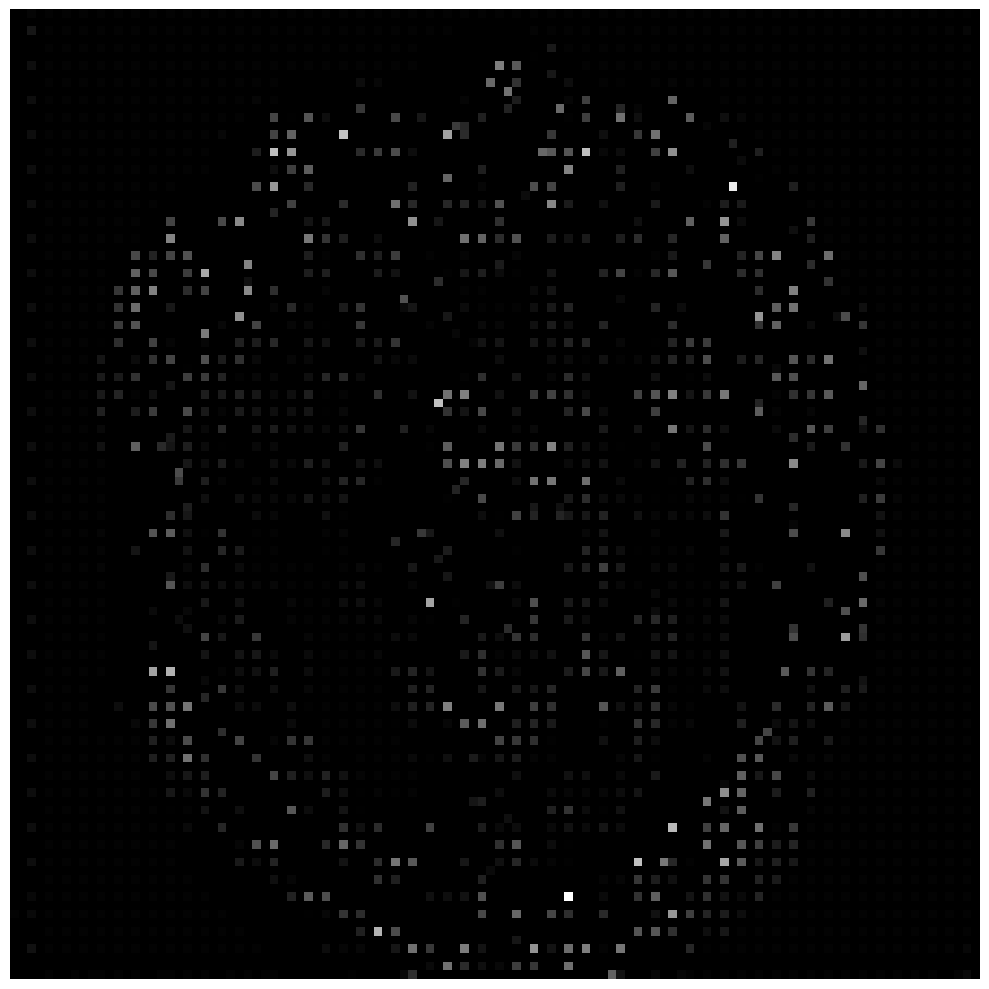

In [13]:
pl.figure(figsize = (10, 10))
pl.imshow(deconv_net.batches[4].detach().numpy()[0, 2, :], cmap = 'gray')
pl.axis('off')
pl.tight_layout()
# pl.savefig('decnn_second_relu.png')

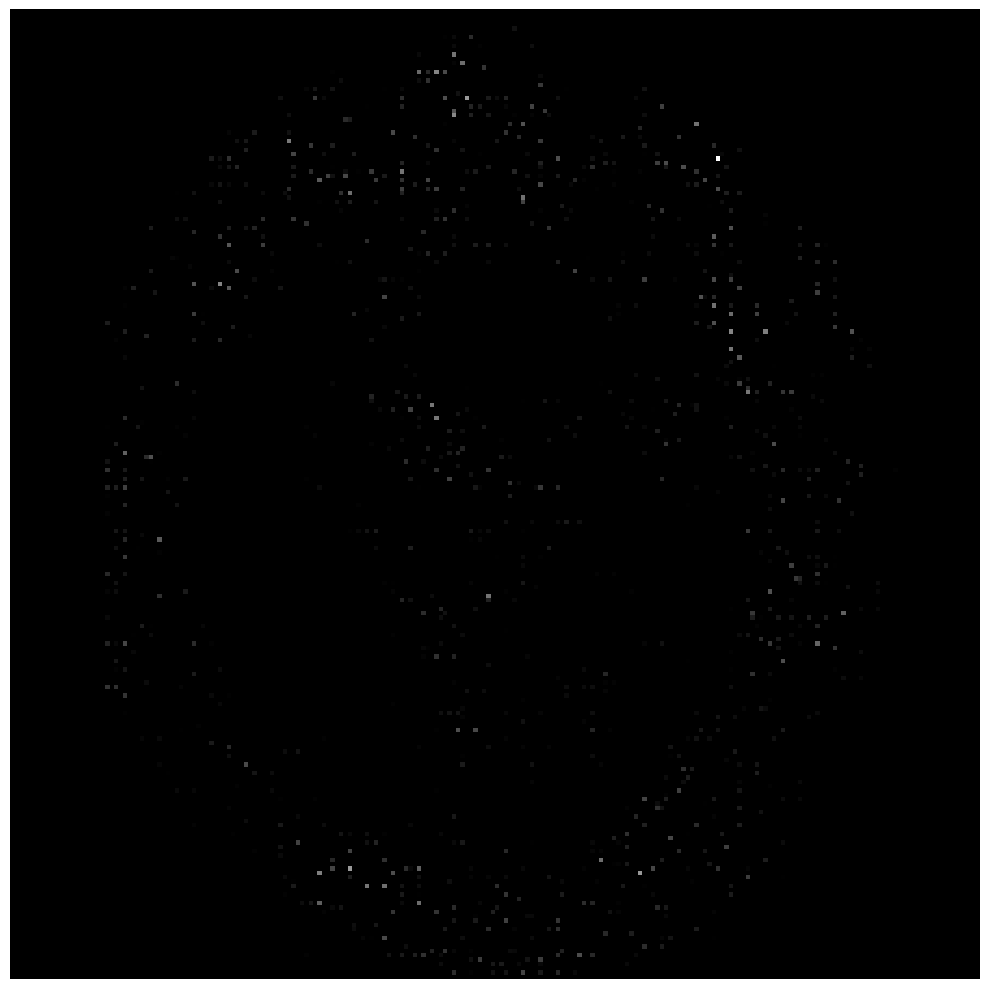

In [14]:
pl.figure(figsize = (10, 10))
pl.imshow(deconv_net.batches[7].detach().numpy()[0, 2, :], cmap = 'gray')
pl.axis('off')
pl.tight_layout()
# pl.savefig('decnn_third_relu.png')

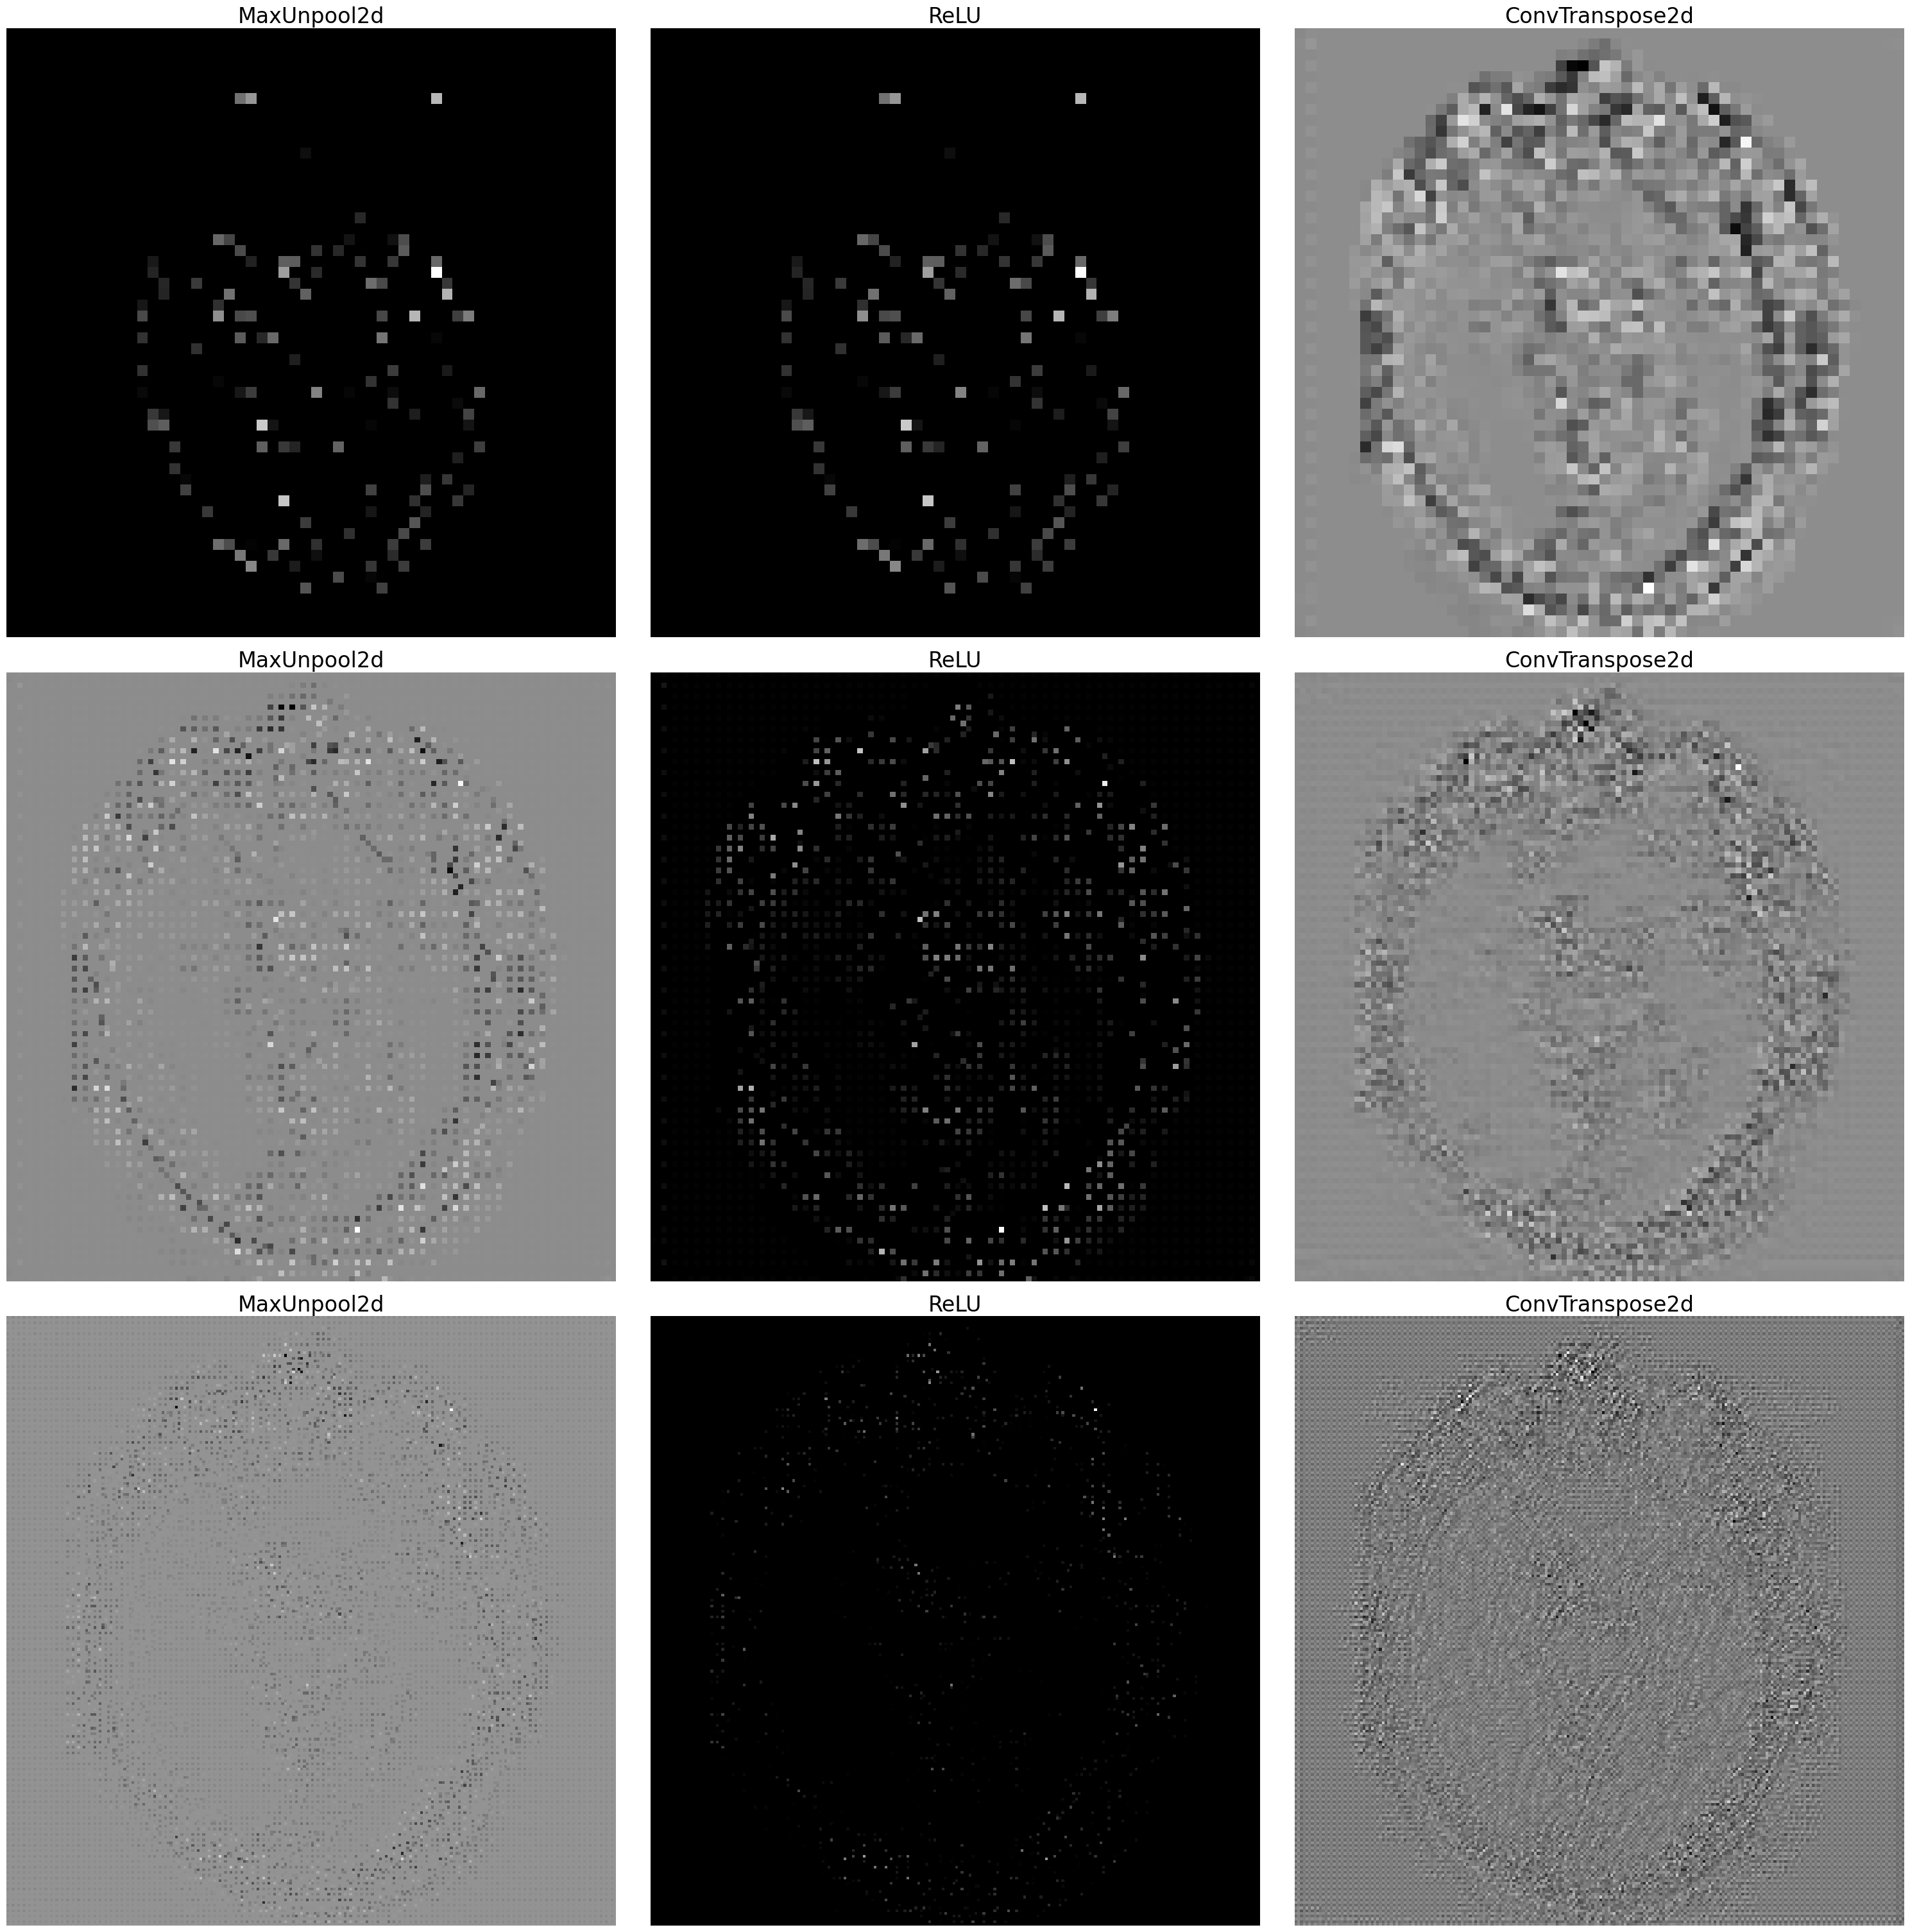

In [15]:
pl.rcParams.update({'font.size': 20})
f, ax = pl.subplots(3, 3, figsize = (30, 30), constrained_layout = True)
index = 0

for row in ax:
  for col in row:
    col.imshow(deconv_net.batches[index].detach().numpy()[0, 2, :], cmap = 'gray')
    col.axis('off')
    col.set_title(f'{layer_names[index]}')
    index += 1
pl.show()